### Machine Learning Lab13 Exercise: MDP-based Shortest Path Solver with Collision Avoidance

In this lab, we are about to find a shortest path with collision avoidance using MDP. We will model the problem as a MDP problem and use **value iteration** or **policy iteration** algorithm to solve it.

#### Environment Data

- Environment: `map_matrix.npy` has environment data. You need to use `numpy` to load  it.
  - <font color=black>White block</font>: an agent, for example, a robot
  - <font color=red>Red block</font>: destination
  - <font color=green>Green block</font>: obstacle

- $\mathscr{R}$ Reward: reward is implemented in code and it only concerns the next state:
  - wall: $-1$
  - destination: 0
  - else: $-0.1$
- $\mathscr{P}$ State transformation: next state is deterministic when taking an action under a certain state.
- $\pi$ Initial policy: each direction (up, right, bottom, left) has equal probability.

### Initialize

In [34]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


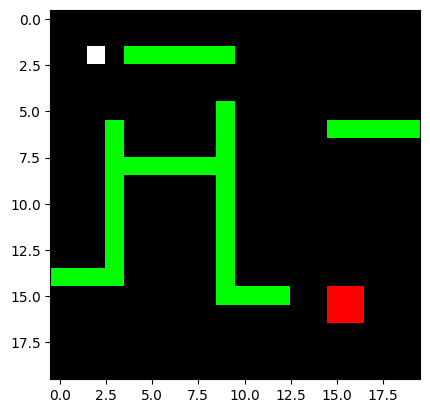

In [35]:
map_matrix = np.load("map_matrix.npy")
plt.imshow(map_matrix)
plt.show()

In [36]:
MAX_Y = map_matrix.shape[0]
MAX_X = map_matrix.shape[1]
noS = MAX_Y * MAX_X
noA = 4

In [37]:
# A, defining action variables
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

# S, a sequence of number rather than coordinates
S = range(noS)

# reward
reward_blank = -0.1  # for every step -1 in other states
reward_wall = -1  # for wall
reward_goal = 0  # for destination
wall = []
goal = []
start = None
for y in range(MAX_Y):
    for x in range(MAX_X):
        if list(map_matrix[y][x]) == [0.0, 30.0, 0.0]:
            wall.append(y * MAX_X + x)
        elif list(map_matrix[y][x]) == [255.0, 0.0, 0.0]:
            goal.append(y * MAX_X + x)
        elif list(map_matrix[y][x]) == [255.0, 255.0, 255.0]:
            start = (y, x)
print("--> State of walls:", wall)
print("--> State of destination:", goal)

# P[s][a] = (state transition probability, next state, reward, done)
P = dict()
grid = np.arange(noS).reshape(map_matrix.shape[0:2])
it = np.nditer(grid, flags=["multi_index"])

while not it.finished:
    stt = it.iterindex
    y, x = it.multi_index
    P[stt] = dict()
    # if (terminal_state(s)):
    if stt in goal:  # s in terminal_state:
        P[stt][UP] = (1.0, stt, reward_goal, True)
        P[stt][RIGHT] = (1.0, stt, reward_goal, True)
        P[stt][DOWN] = (1.0, stt, reward_goal, True)
        P[stt][LEFT] = (1.0, stt, reward_goal, True)
    else:
        ns_up = stt if y == 0 else stt - MAX_X
        ns_right = stt if x == (MAX_X - 1) else stt + 1
        ns_down = stt if y == (MAX_Y - 1) else stt + MAX_X
        ns_left = stt if x == 0 else stt - 1

        if stt in goal:
            rw = reward_goal
        elif stt in wall:
            rw = reward_wall
        else:
            rw = reward_blank

        P[stt][UP] = (1.0, ns_up, rw, ns_up in goal)
        P[stt][RIGHT] = (1.0, ns_right, rw, ns_right in goal)
        P[stt][DOWN] = (1.0, ns_down, rw, ns_down in goal)
        P[stt][LEFT] = (1.0, ns_left, rw, ns_left in goal)
    it.iternext()

print("--> Number of states in grid: " + str(noS))
print("--> Number of action options in each state:" + str(noA))
print("--> Transition probabilities matrix(prob, next_state, reward, is_done)：")
print(P[0])

--> State of walls: [44, 45, 46, 47, 48, 49, 109, 123, 129, 135, 136, 137, 138, 139, 143, 149, 163, 164, 165, 166, 167, 168, 169, 183, 189, 203, 209, 223, 229, 243, 249, 263, 269, 280, 281, 282, 283, 289, 309, 310, 311, 312]
--> State of destination: [315, 316, 335, 336]
--> Number of states in grid: 400
--> Number of action options in each state:4
--> Transition probabilities matrix(prob, next_state, reward, is_done)：
{0: (1.0, 0, -0.1, False), 1: (1.0, 1, -0.1, False), 2: (1.0, 20, -0.1, False), 3: (1.0, 0, -0.1, False)}


### Optimization Approach

In [38]:
def value_iteration(P, theta=0.001, discount_factor=1.0):
    """
    Value iteration

    :param theta: threshold to stop iteration
    :param discount_factor: the same as discount factor in formula
    :return: a policy and a state-value matrix V
    """
    it = 1
    V = np.random.rand(noS)
    V[goal] = 0
    policy = np.zeros([noS, noA])
    delta = 6
    while delta > theta:
        delta = 0
        for stt in range(noS):
            v = V[stt]
            maxv = -np.inf
            maxa = 0
            for cura in range(noA):
                prob, nex, rewa, _ = P[stt][cura]
                curv = prob * (rewa + discount_factor * V[nex])
                # print(f"curv: {curv}")
                if curv > maxv:
                    maxv = curv
                    maxa = cura
            V[stt] = maxv
            policy[stt] = np.zeros(noA)
            policy[stt, maxa] = 1
            delta = max(delta, abs(v - V[stt]))
            print(f"{it}: {delta}")
            it += 1

    # TODO: find the best policy according to V
    # Create a deterministic policy using the optimal value function
    # policy[s, a] means the probability of taking action a under state s, in this case, they are one-hot

    return policy, V

In [39]:
def policy_eval(policy_matrix, P_matrix, discount_factor=1.0, theta=0.00001):
    # Start with a random (all 0) value function
    V = np.ones(noS) * -np.inf
    V[goal] = 0
    delta = 6
    while delta > theta:
        delta = 0
        for s in range(noS):
            v = V[s].copy()
            a = np.argmax(policy_matrix[s])
            prob, nex, rewa, _ = P_matrix[s][a]
            V[s] = max(V[s], prob * (rewa + discount_factor * V[nex]))
            delta = max(delta, abs(v - V[s]))
    return np.array(V)


def policy_improvement(P_matrix, policy_eval_fn=policy_eval, discount_factor=1.0):
    # Start with a random policy
    V = np.ones(noS) * -np.inf
    V[goal] = 0
    policy_now = np.zeros([noS, noA])
    for s in range(noS):
        a = np.random.randint(noA)
        policy_now[s, a] = 1
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy_now, P_matrix, discount_factor)

        # Will be set to false if we make any changes to the policy
        policy_stable = True

        # For each state...
        for s in range(noS):
            old = policy_now[s].copy()
            maxv = -np.inf
            maxa = None
            for cura in range(noA):
                prob, nex, rewa, _ = P[s][cura]
                curv = prob * (rewa + discount_factor * V[nex])
                if curv > maxv:
                    maxv = curv
                    maxa = cura
            policy_now[s] = np.zeros(noA)
            policy_now[s, maxa] = 1
            if not np.all(old == policy_now[s]):
                policy_stable = False
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy_now, V

In [40]:
# iteration = policy_improvement
iteration = value_iteration
policy, v = iteration(P)

1: 0.09999999999999998
2: 0.09999999999999998
3: 0.36946536913492667
4: 0.5119994019377677
5: 0.5119994019377677
6: 0.5119994019377677
7: 0.5119994019377677
8: 0.5119994019377677
9: 0.59560490732385
10: 0.59560490732385
11: 0.59560490732385
12: 0.59560490732385
13: 0.7302070794954534
14: 0.7302070794954534
15: 0.7302070794954534
16: 0.7302070794954534
17: 0.7302070794954534
18: 0.7302070794954534
19: 0.7302070794954534
20: 0.7302070794954534
21: 0.7302070794954534
22: 0.7302070794954534
23: 0.7302070794954534
24: 0.7302070794954534
25: 0.7302070794954534
26: 0.7302070794954534
27: 0.7302070794954534
28: 0.7302070794954534
29: 0.7302070794954534
30: 0.7302070794954534
31: 0.7302070794954534
32: 0.7302070794954534
33: 0.7302070794954534
34: 0.7302070794954534
35: 0.7302070794954534
36: 0.7302070794954534
37: 0.7302070794954534
38: 0.7302070794954534
39: 0.7302070794954534
40: 0.7302070794954534
41: 0.7302070794954534
42: 0.7302070794954534
43: 0.7302070794954534
44: 0.7302070794954534
45

### Display

In [41]:
from IPython.display import clear_output
from pygame.time import wait


# display modules
def display_policy(
    policy_map: np.ndarray, des=((15, 16), (15, 15), (16, 15), (16, 16))
):
    """
    Display policy in a vector field
    :param des: destination, for dying quiver
    :param policy_map: your policy map where each position is a number standing for an action
    :return:
    """

    def phrase_action(action: int):
        if action == 0:
            return 0, 1
        if action == 1:
            return 1, 0
        if action == 2:
            return 0, -1
        if action == 3:
            return -1, 0
        return 0, 0

    des = np.asarray(np.copy(des))

    X, Y = policy_map.shape
    grid_X = np.arange(X).reshape(-1, 1).repeat(Y, axis=1)
    grid_Y = np.arange(Y).reshape(1, -1).repeat(X, axis=0)
    direct_X, direct_Y = [], []
    C = []
    for x_row in list(zip(grid_X, grid_Y)):
        for p in tuple(zip(x_row[0], x_row[1])):
            direct_x, direct_y = phrase_action(policy_map[p[0], p[1]])
            direct_X.append(direct_x)
            direct_Y.append(direct_y)
            if des is not None:
                C.append(np.sum(np.abs(p - des)))
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")  # 将X坐标轴移到上面
    ax.invert_yaxis()  # 反转Y坐标轴
    plt.quiver(grid_X, grid_Y, direct_X, direct_Y, 0 if len(C) == 0 else C)
    plt.show()


def display_v(V: np.ndarray, map_m: np.ndarray):
    """
    display state value in heat map
    :param map_m: 2D map matrix corresponding to v
    :param V: state value, 1D
    :return:
    """

    heatmap = V.reshape(map_m.shape[0:2])
    plt.imshow(heatmap, cmap=plt.cm.summer)
    plt.colorbar()
    plt.show()


def display_path(policy_map, map_mm, departure, des, max_iter=100):
    """

    :param policy_map: policy
    :param map_m: map
    :param departure: start point
    :param des: destination
    :return:
    """
    map_m = np.copy(map_mm)

    now_y, now_x = departure
    iter_n = 0
    while now_y * MAX_X + now_x not in des:
        if iter_n > max_iter:
            break
        map_matrix[now_y, now_x, :] = np.array([151, 255, 255])
        if UP == policy_map[now_y, now_x]:
            now_y = now_y - 1
        elif RIGHT == policy_map[now_y, now_x]:
            now_x = now_x + 1
        elif DOWN == policy_map[now_y, now_x]:
            now_y = now_y + 1
        elif LEFT == policy_map[now_y, now_x]:
            now_x = now_x - 1
        now_y = (now_y + MAX_Y) % MAX_Y
        now_x = (now_x + MAX_X) % MAX_X
        map_m[now_y, now_x, :] = 120
        plt.imshow(map_m)
        plt.show()
        wait(100)
        clear_output(wait=True)

        iter_n += 1

Grid Policy (0=up, 1=right, 2=down, 3=left):


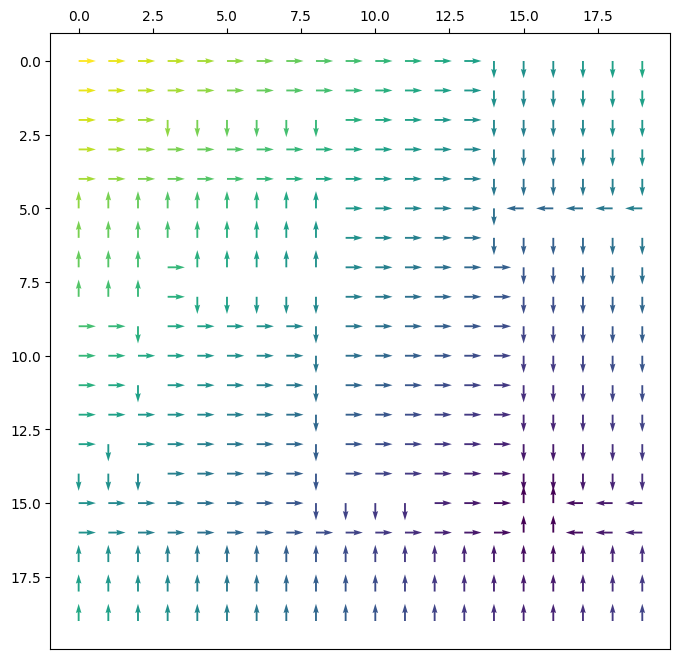

In [42]:
print("Grid Policy (0=up, 1=right, 2=down, 3=left):")
grid_policy = np.reshape(np.argmax(policy, axis=1), map_matrix.shape[0:2])
display_policy(grid_policy.T)

State value:


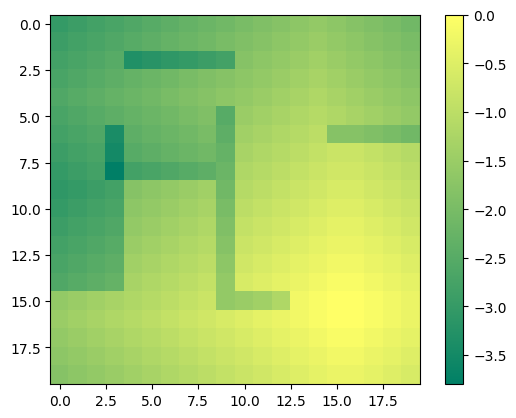

In [43]:

print("State value:")
display_v(v, map_matrix)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


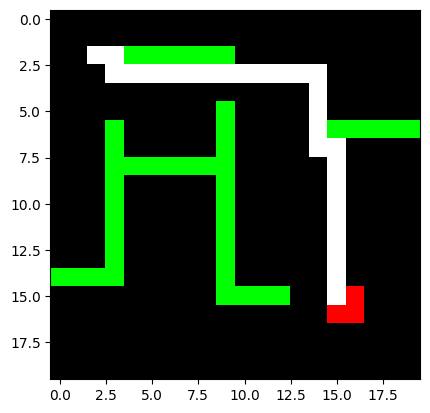

In [44]:
%matplotlib inline
display_path(grid_policy, map_matrix, start, goal)